In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size

        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X, Y = build_dataset(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [6]:
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias

        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [7]:
torch.manual_seed(42)

In [8]:
n_embd = 10
n_hidden = 200
C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [9]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    
    loss = F.cross_entropy(x, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i <= 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7613
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1327


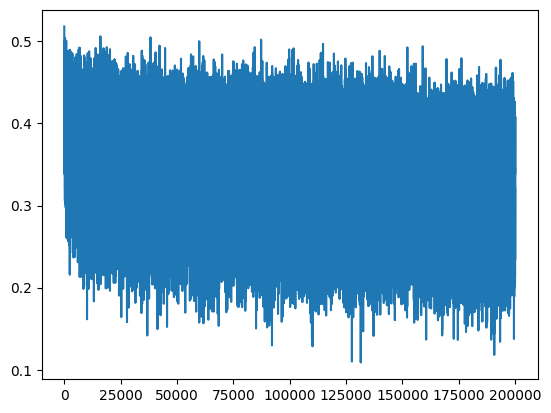

In [10]:
plt.plot(lossi)

In [11]:
for layer in layers:
    layer.training = False

In [12]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583252906799316
val 2.106532335281372


In [15]:
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)

        for layer in layers:
            x = layer(x)

        probs = F.softmax(x, dim=1);
        ix = torch.multinomial(probs, num_samples=1).item()
        
        prob_sum = 0
        for j in range(27):
            prob_sum += probs[:, j].item()
        
        if ix == 0:
            break

        context = context[1:] + [ix]
        out.append(ix)

    print(''.join(itos[i] for i in out))

zisha
moslefriel
nakend
karpnenrim
grayer
raya
zaydan
mavah
celimana
brah
ton
calder
shiannah
jahdyn
brah
nah
eminiah
blak
alom
juliegan
